In [172]:
# import the right modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

In [167]:
# read the data
data = pd.read_csv('bank.csv', sep=';').drop_duplicates()
print(data.head())
print(data.info())

   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #  

In [168]:
# Data cleaning and pre-processing
# check for missing values
print(data.isna().sum())
print(data.dtypes)


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


In [169]:
# get the descriptive statistics of the data
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


# 1.0 Data visualization
Visualize categorical and non-categorical data for better understanding

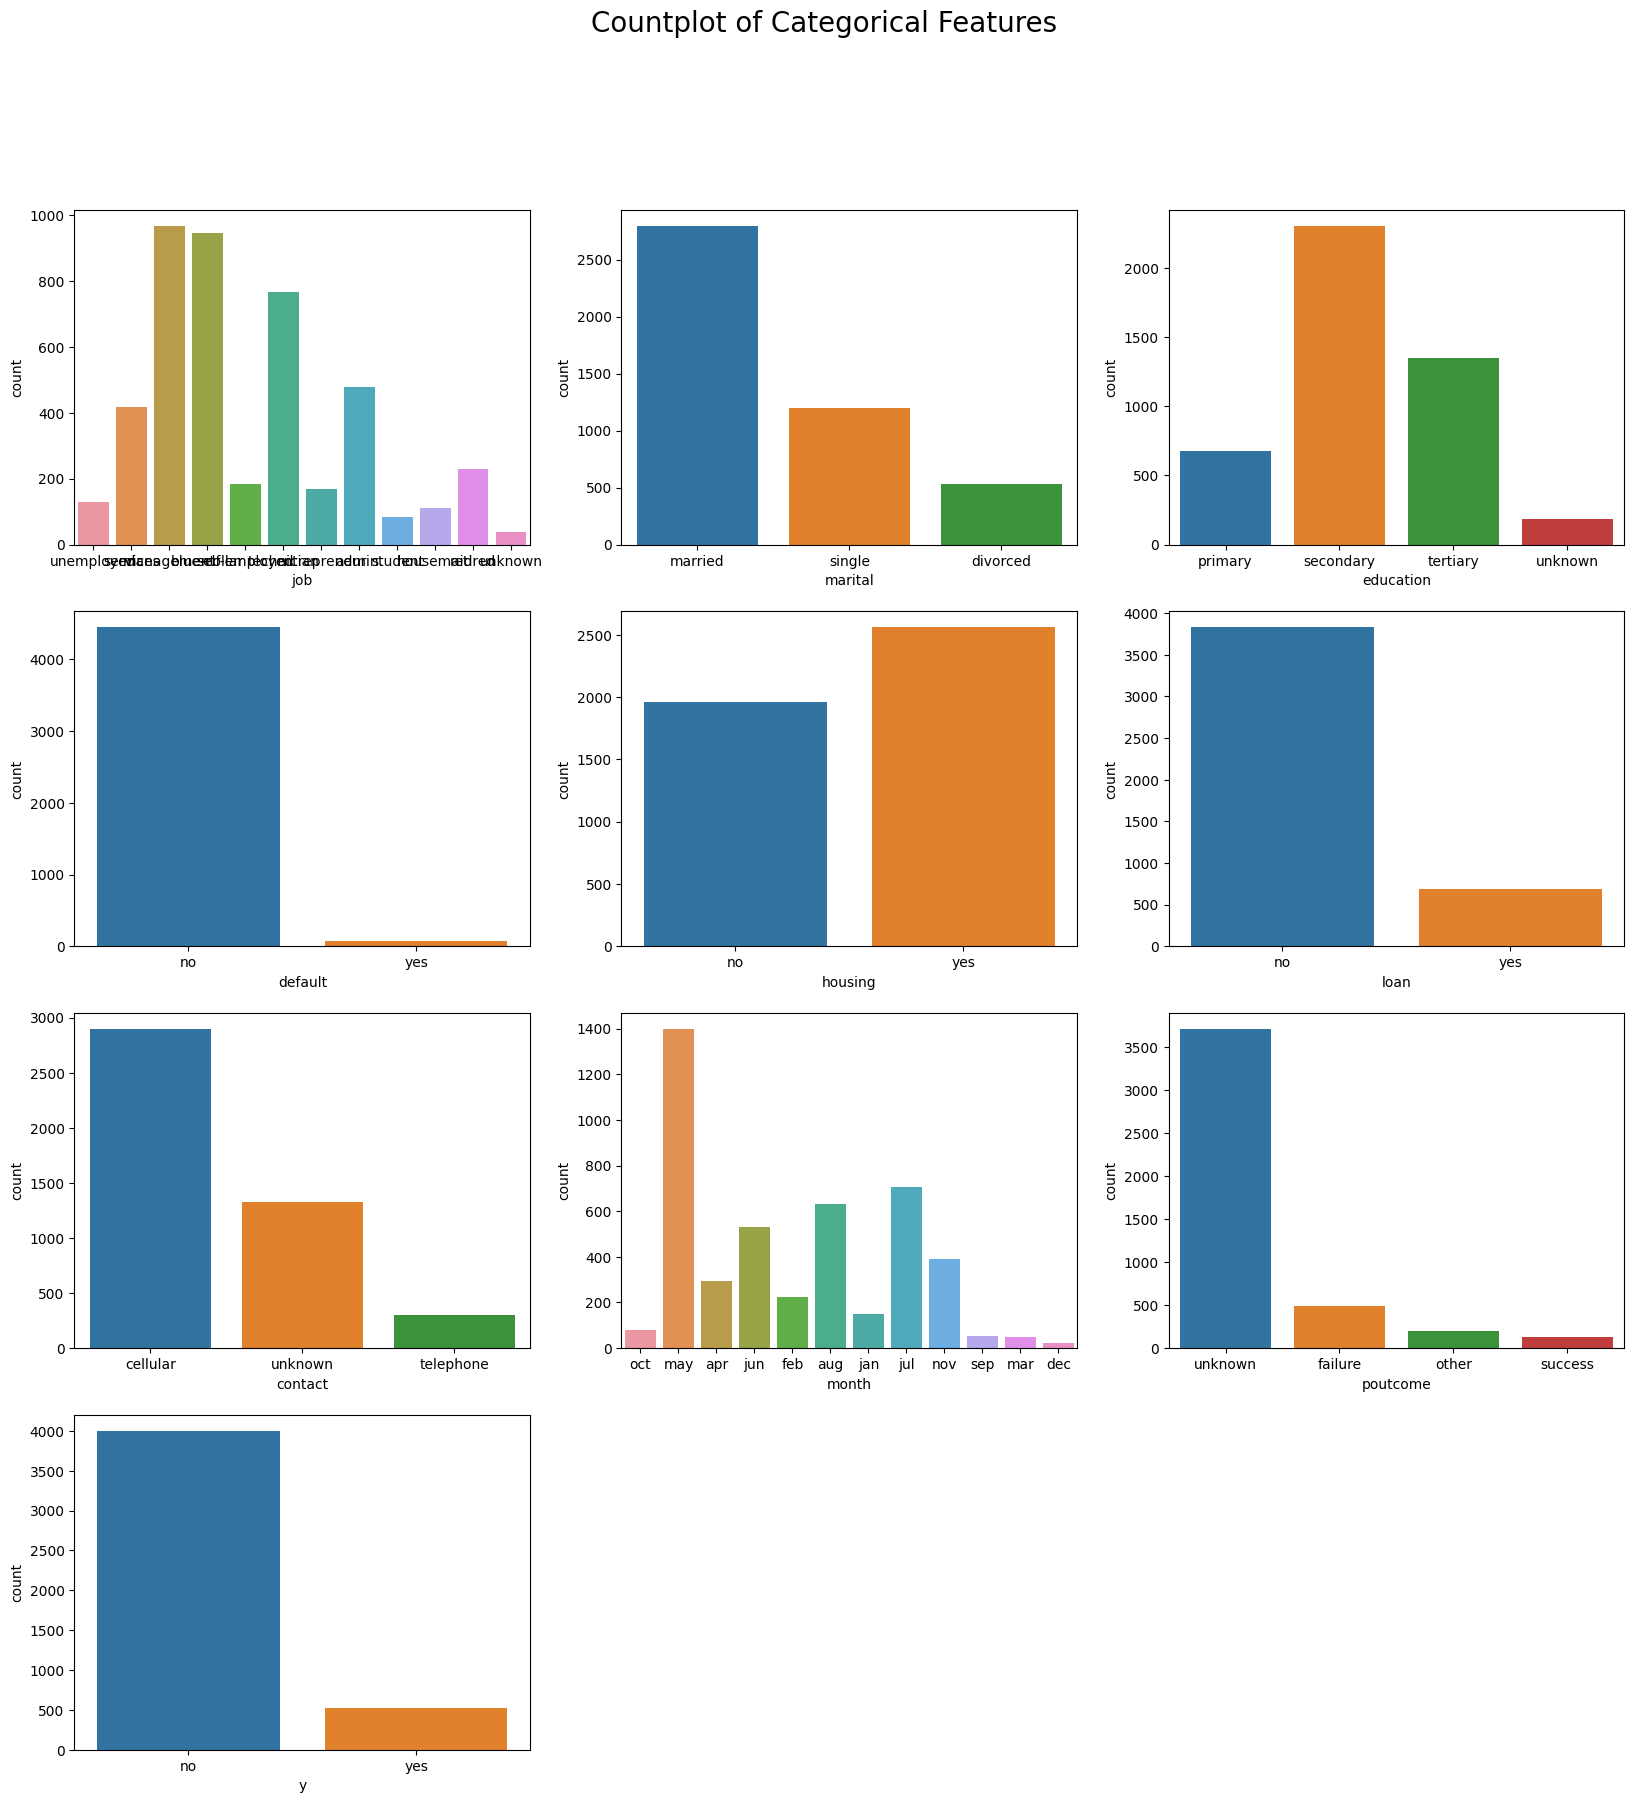

In [170]:
# get the countplot for categorical features
category_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
# create subplots to allow printing of all the countplots in one figure 
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

# loop through the category features and plot the countplot
for category in category_features:
    sns.countplot(x=category, data=data, ax=axes[category_features.index(category) // 3, category_features.index(category) % 3])
for i in range(len(category_features), len(axes.flat)):
    fig.delaxes(axes.flatten()[i])

plt.suptitle('Countplot of Categorical Features', fontsize=20)
plt.show()



KeyboardInterrupt: 

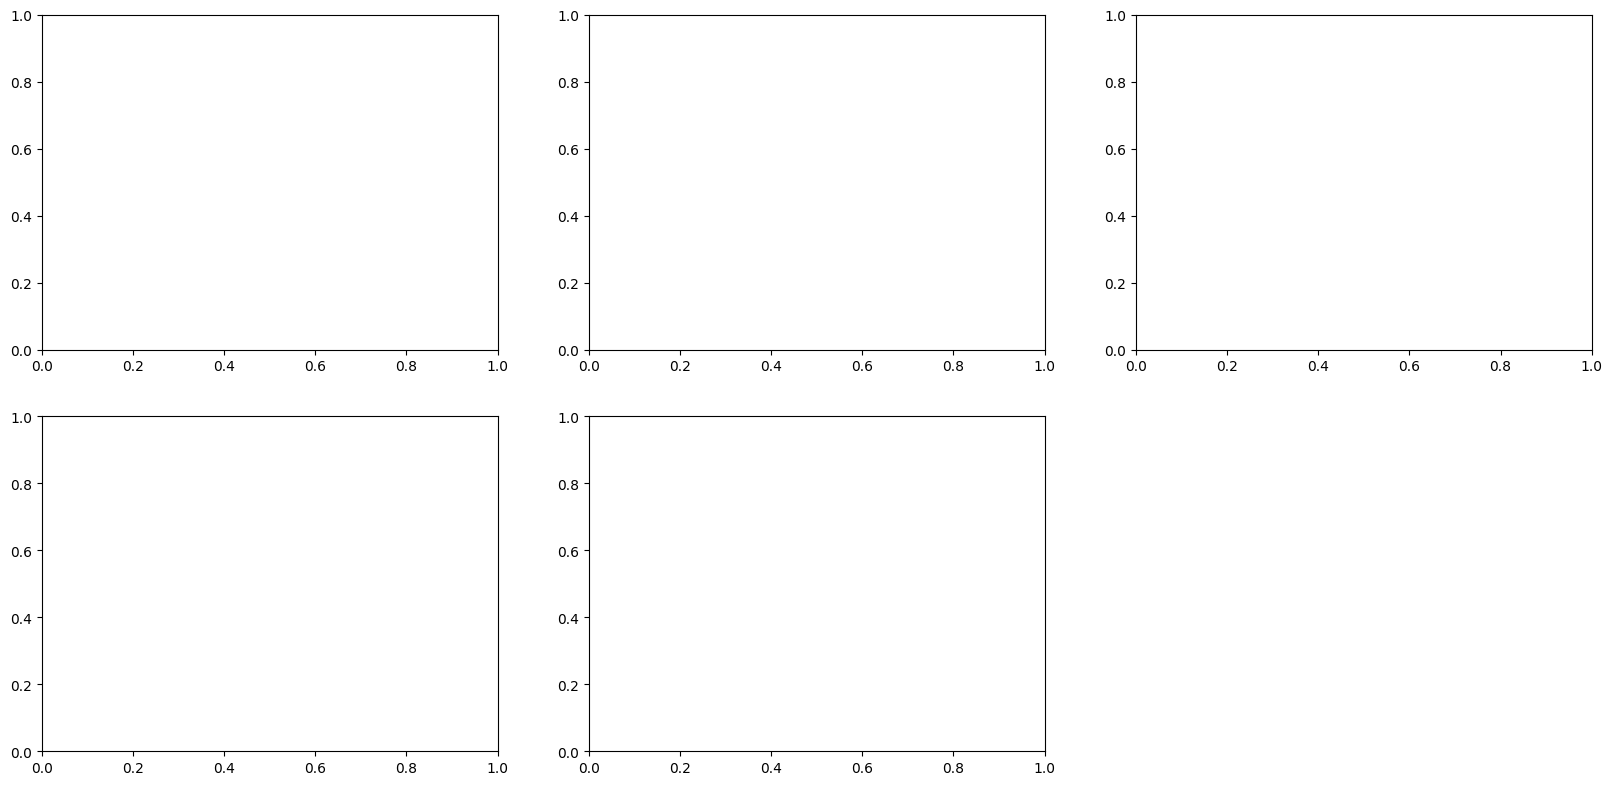

In [171]:
# plot the non-category features
non_category_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
# create subplots to allow printing of all the countplots in one figure 
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

# loop through the category features and plot the countplot
for category in non_category_features:
    sns.histplot(x=category, data=data, ax=axes[non_category_features.index(category) // 3, non_category_features.index(category) % 3])
for i in range(len(non_category_features), len(axes.flat)):
    fig.delaxes(axes.flatten()[i])
plt.suptitle('Histogram of non-category features')
plt.show()



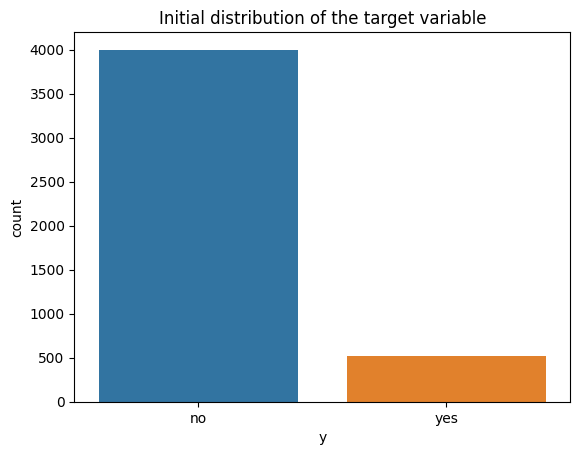

In [ ]:
# get the current distribution of the target variable (y)
sns.countplot(x='y', data=data)
plt.title('Initial distribution of the target variable')
plt.show()


# 2.0 Data Encoding

In [ ]:
# perfomr one-hot encoding on the categorical features
hot_data = pd.get_dummies(data, columns=category_features[:-1], drop_first=True)
hot_data.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,no,False,False,...,False,False,False,False,False,True,False,False,False,True
1,33,4789,11,220,1,339,4,no,False,False,...,False,False,False,True,False,False,False,False,False,False
2,35,1350,16,185,1,330,1,no,False,False,...,False,False,False,False,False,False,False,False,False,False
3,30,1476,3,199,4,-1,0,no,False,False,...,False,True,False,False,False,False,False,False,False,True
4,59,0,5,226,1,-1,0,no,True,False,...,False,False,False,True,False,False,False,False,False,True


### 2.1 Observation1

* using one-hot encoding increases the columns from 17 columns to 43 columns. 
* While we've dropped some of the binary variables created (9) to reduce multicollinerity, this is still a significant increase in data frame dimension. 
* The following cell performs label encoding to explore an alternative to one-hot encoding

In [ ]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in category_features:
    data[column] = le.fit_transform(data[column])
data.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0


In [ ]:
# Seperate the input data from the target variable y
x = data.iloc[:,:-1]
y = data.iloc[:, -1]
x.head()
y.head()


0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int32

In [ ]:
print(x.shape, y.shape)

(4521, 16) (4521,)


In [ ]:
# Explore the concept of oversampling and undersampling
# check the counts of the target variables to see distribution of the targets
# pandas.value_counts to get the unique values in target var
print(y.value_counts())

y
0    4000
1     521
Name: count, dtype: int64


### 2.2 Observation 2
* It is clear that the target variable (y) has a high level of imbalance
* There are 4000 instances of 0 (no loan approval) and only 521 (Loan approved)
* This **class imbalance** could potentially lead to false accuracy metrics as the resulting model may be biased towards the majority class
* *Remedy* is to use an oversampling technique to synthetically increase the minority class.
* *Trade off;* Oversampling may expose the model to overfitting. Use regularization and cross validation to reduce overfitting

y
0    4000
1    4000
Name: count, dtype: int64


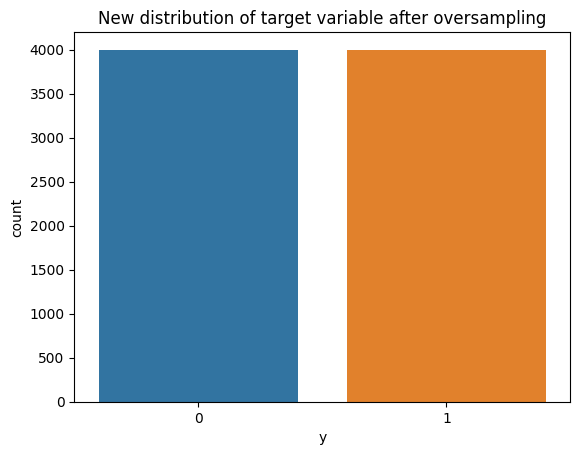

In [ ]:
ros = RandomOverSampler()
x, y = ros.fit_resample(x, y)
print(y.value_counts())
sns.countplot(x=y, data=data)
plt.title('New distribution of target variable after oversampling')
plt.show()

### 2.3 Split the data into testing, validation and training data

In [ ]:

# feature scaling
from sklearn.preprocessing import MinMaxScaler


ms=MinMaxScaler()
x=ms.fit_transform(x)
x
# split x and y to training and temporary sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=4)
# split the temporary dataset into validation and testing sets 
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

x_train_lstm = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test_lstm = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_val_lstm = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

Train set: (5600, 16) (5600,)
Test set: (1200, 16) (1200,)


# 3.0 MACHINE LEARNING MODELS

### 3.1 Model without optimization techniques

In [173]:
def create_model(input_shape, lstm_units, dense_units, n_dense_layers=1, activation='relu', output_activation='sigmoid', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape))
    
    for _ in range(n_dense_layers):
        model.add(Dense(dense_units, activation=activation))
    
    model.add(Dense(1, activation=output_activation))
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Now you can create a model with multiple Dense layers by calling the function
model_1 = create_model(input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]), lstm_units=50, dense_units=10, n_dense_layers=3)

# Train the model
model_1.fit(x_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(x_val_lstm, y_test))
# Create the directory if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Save the model
model_1.save('saved_models/model_1.h5')

# Evaluate the model
_, accuracy = model_1.evaluate(x_val_lstm, y_val)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Epoch 1/20
175/175 [==============================] - 3s 5ms/step - loss: 0.6807 - accuracy: 0.6007 - val_loss: 0.6941 - val_accuracy: 0.5192
Epoch 2/20
175/175 [==============================] - 0s 2ms/step - loss: 0.6109 - accuracy: 0.7189 - val_loss: 0.7404 - val_accuracy: 0.5050
Epoch 3/20
175/175 [==============================] - 0s 2ms/step - loss: 0.5106 - accuracy: 0.7795 - val_loss: 0.9025 - val_accuracy: 0.5092
Epoch 4/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4695 - accuracy: 0.7921 - val_loss: 0.9787 - val_accuracy: 0.5125
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4574 - accuracy: 0.7980 - val_loss: 0.9915 - val_accuracy: 0.5100
Epoch 6/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4500 - accuracy: 0.7966 - val_loss: 1.0013 - val_accuracy: 0.5100
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.8012 - val_loss: 1.0237 - val_accuracy: 0.5033
Epoch 

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.8017
Model Accuracy: 80.17%


#### 3.1.1 Model 1 error analysis

38/38 [==============================] - 0s 2ms/step
Specificity: 0.83


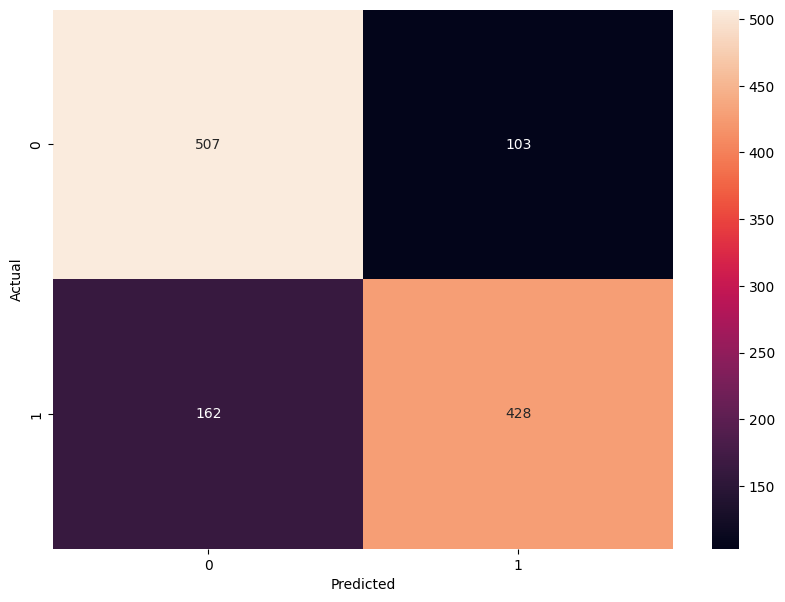

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       610
           1       0.81      0.73      0.76       590

    accuracy                           0.78      1200
   macro avg       0.78      0.78      0.78      1200
weighted avg       0.78      0.78      0.78      1200



In [ ]:
y_pred = (model_1.predict(x_val_lstm) > 0.5).astype("int32")
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
TN = cm[0, 0]
FP = cm[0, 1]

specificity = TN / (TN + FP)
print(f'Specificity: {specificity:.2f}')

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report (precision, recall, and f1 score)
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


### 3.2 Model with 3 optimization techniques

#### 3.2.1 Optimizer 1: Schochastic Gradient Descent(SGD)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_2 = create_model(input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]), lstm_units=50, dense_units=10, n_dense_layers=3)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model_2.fit(x_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(x_val_lstm, y_test))
_, accuracy = model_2.evaluate(x_val_lstm, y_val)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Epoch 1/20
175/175 [==============================] - 3s 6ms/step - loss: 0.6716 - accuracy: 0.6241 - val_loss: 0.6988 - val_accuracy: 0.5250
Epoch 2/20
175/175 [==============================] - 1s 3ms/step - loss: 0.5707 - accuracy: 0.7314 - val_loss: 0.8144 - val_accuracy: 0.5183
Epoch 3/20
175/175 [==============================] - 1s 3ms/step - loss: 0.4870 - accuracy: 0.7805 - val_loss: 0.9501 - val_accuracy: 0.5117
Epoch 4/20
175/175 [==============================] - 0s 3ms/step - loss: 0.4621 - accuracy: 0.7941 - val_loss: 1.0059 - val_accuracy: 0.5033
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4528 - accuracy: 0.7959 - val_loss: 1.0470 - val_accuracy: 0.5050
Epoch 6/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4467 - accuracy: 0.8045 - val_loss: 1.0576 - val_accuracy: 0.5050
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.8059 - val_loss: 1.0935 - val_accuracy: 0.5008
Epoch 

#### 3.2.2 Optimizer 2: RMSprop

In [174]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_3 = create_model(input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]), lstm_units=50, dense_units=10, n_dense_layers=3)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model_3.fit(x_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(x_val_lstm, y_test))
_, accuracy = model_3.evaluate(x_val_lstm, y_val)
print(f'Model Accuracy: {accuracy * 100:.2f}%')
model_3.save('saved_models/best_model.h5')

Epoch 1/50
175/175 [==============================] - 3s 5ms/step - loss: 0.6561 - accuracy: 0.6182 - val_loss: 0.7226 - val_accuracy: 0.5217
Epoch 2/50
175/175 [==============================] - 0s 2ms/step - loss: 0.5504 - accuracy: 0.7366 - val_loss: 0.8362 - val_accuracy: 0.5208
Epoch 3/50
175/175 [==============================] - 0s 2ms/step - loss: 0.4758 - accuracy: 0.7871 - val_loss: 1.0293 - val_accuracy: 0.5008
Epoch 4/50
175/175 [==============================] - 0s 2ms/step - loss: 0.4573 - accuracy: 0.7912 - val_loss: 1.0309 - val_accuracy: 0.5050
Epoch 5/50
175/175 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.7987 - val_loss: 1.0278 - val_accuracy: 0.5000
Epoch 6/50
175/175 [==============================] - 0s 3ms/step - loss: 0.4453 - accuracy: 0.8023 - val_loss: 1.1037 - val_accuracy: 0.5017
Epoch 7/50
175/175 [==============================] - 0s 2ms/step - loss: 0.4423 - accuracy: 0.8054 - val_loss: 1.1822 - val_accuracy: 0.5058
Epoch 

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 3.2.3 Optimizer 3: ADAM optimizer

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_4 = create_model(input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]), lstm_units=50, dense_units=10, n_dense_layers=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_4.fit(x_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(x_val_lstm, y_test))
_, accuracy = model_4.evaluate(x_val_lstm, y_val)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Epoch 1/50
175/175 [==============================] - 3s 5ms/step - loss: 0.6810 - accuracy: 0.5546 - val_loss: 0.7026 - val_accuracy: 0.5017
Epoch 2/50
175/175 [==============================] - 0s 2ms/step - loss: 0.6160 - accuracy: 0.6966 - val_loss: 0.7643 - val_accuracy: 0.5117
Epoch 3/50
175/175 [==============================] - 0s 2ms/step - loss: 0.5163 - accuracy: 0.7614 - val_loss: 0.9730 - val_accuracy: 0.5017
Epoch 4/50
175/175 [==============================] - 0s 2ms/step - loss: 0.4634 - accuracy: 0.7862 - val_loss: 1.0124 - val_accuracy: 0.5050
Epoch 5/50
175/175 [==============================] - 0s 2ms/step - loss: 0.4522 - accuracy: 0.7993 - val_loss: 1.0960 - val_accuracy: 0.5092
Epoch 6/50
175/175 [==============================] - 0s 2ms/step - loss: 0.4469 - accuracy: 0.7993 - val_loss: 1.1008 - val_accuracy: 0.5067
Epoch 7/50
175/175 [==============================] - 0s 2ms/step - loss: 0.4442 - accuracy: 0.8012 - val_loss: 1.0794 - val_accuracy: 0.4983
Epoch 

#### 3.2.4 Best performing model error analysis

38/38 [==============================] - 0s 4ms/step
Specificity: 0.73


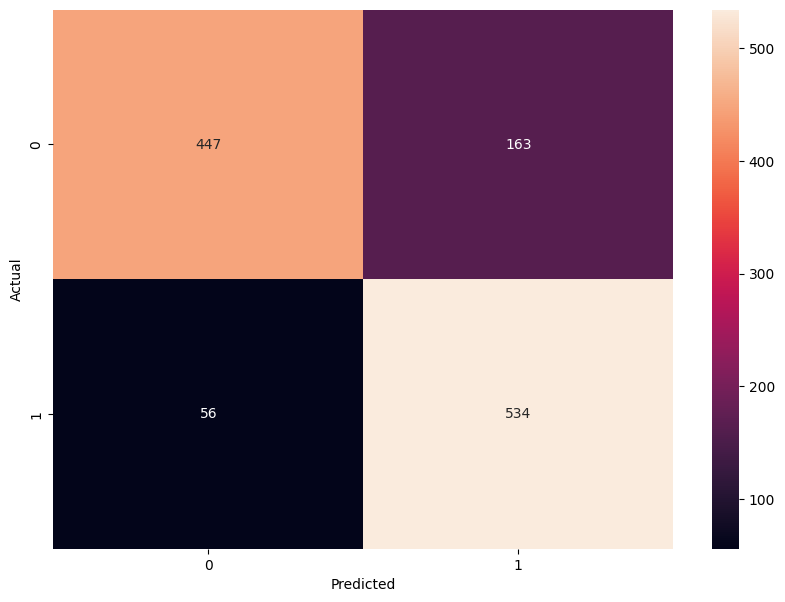

              precision    recall  f1-score   support

           0       0.89      0.73      0.80       610
           1       0.77      0.91      0.83       590

    accuracy                           0.82      1200
   macro avg       0.83      0.82      0.82      1200
weighted avg       0.83      0.82      0.82      1200



In [ ]:
y_pred = (model_3.predict(x_val_lstm) > 0.5).astype("int32")
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
TN = cm[0, 0]
FP = cm[0, 1]

specificity = TN / (TN + FP)
print(f'Specificity: {specificity:.2f}')

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report (precision, recall, and f1 score)
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))